In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import torch.optim as optim
import torchvision.utils as vutils

In [4]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2.0 - 1.0) #to go between -1 and 1
])

In [5]:
class AnimeDataset(Dataset):
    def __init__(self, img_dir='/kaggle/input/animefacedataset/images', transform=None):
        self.img_dir = img_dir
        self.image_files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        
        try:
            image = Image.open(img_path)
        except FileNotFoundError:
            print(f"File not found: {img_path}")
            return None

        if self.transform:
            image = self.transform(image)

        return image

In [6]:
anime_dataset = AnimeDataset(transform=transform)
anime_loader = DataLoader(anime_dataset, batch_size=64, shuffle=True)

In [62]:
from torch.utils.data import Subset
new_dataset = Subset(anime_dataset, indices=range(64))  # İlk 64 öğeyi al

In [67]:
new_dataloader = (DataLoader(new_dataset, batch_size=4, shuffle=True))

In [68]:
images = next(iter(new_dataloader))

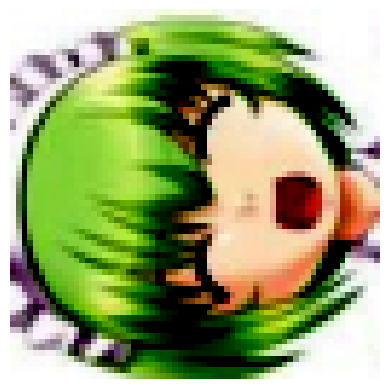

In [124]:
plt.imshow((next(iter(new_dataloader))[0].permute(2, 1, 0)))
plt.axis(False)
plt.show()

In [125]:
class MiniBatchDiscrimination(nn.Module):
    def __init__(self, input_features, output_features, kernel_dims, mean=False, scaling_factor=0.5):
        super(MiniBatchDiscrimination, self).__init__()
        self.input_features = input_features
        self.output_features = output_features
        self.kernel_dims = kernel_dims
        self.mean = mean
        self.scaling_factor = scaling_factor

        self.T = nn.Parameter(torch.Tensor(input_features, output_features, kernel_dims))
        nn.init.normal_(self.T, 0, 1)

    def forward(self, x):
        M = x.mm(self.T.view(self.input_features, -1))
        M = M.view(-1, self.output_features, self.kernel_dims).unsqueeze(0)
        M_T = M.permute(1, 0, 2, 3)
        norm = torch.abs(M - M_T).sum(3)
        expnorm = torch.exp(-norm)
        o_b = (expnorm.sum(0) - 1)
        if self.mean:
            o_b /= x.size(0) - 1

        # scale the o_b
        o_b = self.scaling_factor * o_b
        return torch.cat([x, o_b], 1)

In [126]:
# Constants
IMAGE_SIZE = 64  # Replace with your desired image size
CHANNELS = 3     # RGB channels
Z_DIM = 100      # Latent vector size
NOISE_PARAM = 0.1

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(CHANNELS, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
        )

        self.mbd_layer = MiniBatchDiscrimination(512 * 4 * 4, 128, 8)

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4 + 128, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.mbd_layer(x)
        return self.fc_layers(x)


# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(Z_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, CHANNELS, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)


# Training function
def train_GAN(dataloader, discriminator, generator, num_epochs=5):
    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

    device = torch.device("cuda")
    discriminator = discriminator.to(device)
    generator = generator.to(device)

    for epoch in range(num_epochs):
        # Initialize running loss for discriminator and generator at the start of the epoch
        running_d_loss = 0.0
        running_g_loss = 0.0
        
        # Wrap dataloader with tqdm for progress bar
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}")
        
        for real_images in pbar:
            real_images = real_images.to(device)
            
            batch_size = real_images.size(0)
            
            real_labels = torch.full((batch_size, 1), 1.0, device=device)
            fake_labels = torch.full((batch_size, 1), 0.0, device=device)

            # Train discriminator
            discriminator.zero_grad()
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels)
            d_loss_real.backward()

            noise = torch.randn(batch_size, Z_DIM, 1, 1, device=device)
            fake_images = generator(noise)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels)
            d_loss_fake.backward()
            d_optimizer.step()

            # Sum the discriminator losses
            running_d_loss += d_loss_real.item() + d_loss_fake.item()

            # Train generator
            generator.zero_grad()
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            g_loss.backward()
            g_optimizer.step()

            # Add to the generator running loss
            running_g_loss += g_loss.item()

            # Update progress bar with the current losses
            pbar.set_postfix(D_loss=f"{d_loss_real + d_loss_fake:.4f}", G_loss=f"{g_loss:.4f}")

        # Calculate average losses for the epoch
        avg_d_loss = running_d_loss / len(dataloader)
        avg_g_loss = running_g_loss / len(dataloader)
        
        # Print the average losses
        print(f"Epoch {epoch + 1} - Avg D Loss: {avg_d_loss:.4f}, Avg G Loss: {avg_g_loss:.4f}")

        with torch.no_grad():
            # Generate 10 images
            noise = torch.randn(25, Z_DIM, 1, 1, device=device)
            fake_images = generator(noise)

            # Make a grid
            grid_images = vutils.make_grid(fake_images, nrow=5, normalize=True)

            # Convert the grid_images tensor to a numpy array and then transpose from (C, H, W) to (H, W, C)
            grid_images_np = grid_images.cpu().numpy().transpose(1, 2, 0)

            # Display the grid using matplotlib
            plt.imshow(grid_images_np)
            plt.axis('off')
            plt.title(f"Generated Images at Epoch {epoch + 1}")
            plt.show()